Medical_Q&A using fine-tuned GPT2

* perform data preprocessing, EDA and feature extraction on the Medical Q&A dataset
* load a pre-trained tokenizer
* finetune a GPT-2 language model for medical question-answering

## Dataset Description

The dataset used in this project is the *Medical Question Answering Dataset* ([MedQuAD](https://github.com/abachaa/MedQuAD/tree/master)). It includes medical question-answer pairs along with additional information, such as the question type, the question *focus*, its UMLS(Unified Medical Language System) details like - Concept Unique Identifier(*CUI*) and Semantic *Type* and *Group*.

To know more about this data's collection, and construction method, refer to this [paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3119-4).

The data is extracted and is in CSV format with below features:

- **Focus**: the question focus
- **CUI**: concept unique identifier
- **SemanticType**
- **SemanticGroup**
- **Question**
- **Answer**

Healthcare professionals often have to refer to medical literature and documents while seeking answers to medical queries. Medical databases or search engines are powerful resources of upto date medical knowledge. However, the existing documentation is large and makes it difficult for professionals to retrieve answers quickly in a clinical setting. The problem with search engines and informative retrieval engines is that these systems return a list of documents rather than answers. Instead, healthcare professionals can use question answering systems to retrieve short sentences or paragraphs in response to medical queries. Such systems have the biggest advantage of generating answers and providing hints in a few seconds.

### Problem Statement

Fine-tune gpt2 model on medical-question-answering-dataset for performing response generation for medical queries.

### **GPT-2**

In recent years, the OpenAI GPT-2 exhibited an impressive ability to write coherent and passionate essays that exceeded what current language models can produce. The GPT-2 wasn't a particularly novel architecture - its architecture is very similar to the **decoder-only transformer**. The GPT2 was, however, a very large, transformer-based language model trained on a massive dataset.

Here, you are going to fine-tune the GPT2 model with the Medical data. Expected result should be that the model will be able to reply to the prompt related medical queries after fine-tuning.

To know more about GPT-2, refer [here](http://jalammar.github.io/illustrated-gpt2/).

### Installing Dependencies

In [ ]:
%%capture
!pip -q uninstall pyarrow -y
!pip -q install pyarrow==15.0.2
!pip -q install datasets
!pip -q install accelerate
!pip -q install transformers

### Import required packages

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# read data

In [ ]:
# drive.mount('/content/drive')
data = pd.read_csv("MedQuAD.csv")
data.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
0,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points - Adult acute lymphoblastic leukemi...
1,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


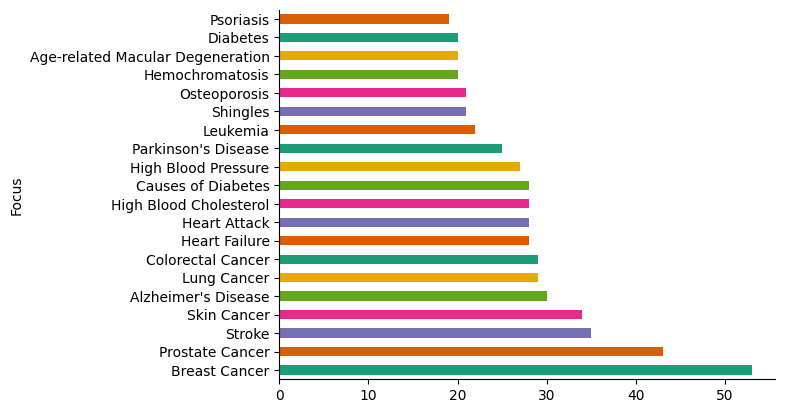

In [ ]:
# @title SemanticFocus

data.groupby('Focus').size().sort_values(ascending=False).head(20).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Pre-processing and EDA

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

**Exercise 2: Perform below operations on the dataset [1 Mark]**

- Handle missing values
- Remove duplicates from data considering `Question` and `Answer` columns

- **Handle missing values**

In [ ]:
for col in data.columns:
  print(col, data[col].isna().sum(), data[col].dtype)

  # because of all objects
  if data[col].isna().sum() > 0:
    data[col].fillna(data[col].mode()[0], inplace=True)

data.isna().any()

Focus 14 object
CUI 565 object
SemanticType 597 object
SemanticGroup 565 object
Question 0 object
Answer 5 object


,0
Focus,False
CUI,False
SemanticType,False
SemanticGroup,False
Question,False
Answer,False


- **Remove duplicates from data considering `Question` and `Answer` columns**

In [ ]:
data.drop_duplicates(subset=['Question', 'Answer'], inplace=True)
data.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
0,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is (are) Adult Acute Lymphoblastic Leukem...,Key Points - Adult acute lymphoblastic leukemi...
1,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What are the symptoms of Adult Acute Lymphobla...,"Signs and symptoms of adult ALL include fever,..."
2,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,How to diagnose Adult Acute Lymphoblastic Leuk...,Tests that examine the blood and bone marrow a...
3,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,What is the outlook for Adult Acute Lymphoblas...,Certain factors affect prognosis (chance of re...
4,Adult Acute Lymphoblastic Leukemia,C0751606,T191,Disorders,Who is at risk for Adult Acute Lymphoblastic L...,Previous chemotherapy and exposure to radiatio...


In [ ]:
data[data['Question'].str.contains('symptoms of Adult Acute Lymphobla')]['Question'].to_list()

['What are the symptoms of Adult Acute Lymphoblastic Leukemia ?']

**Exercise 3: Display the category name, and the number of records belonging to top 100 categories of `Focus` column [1 Mark]**

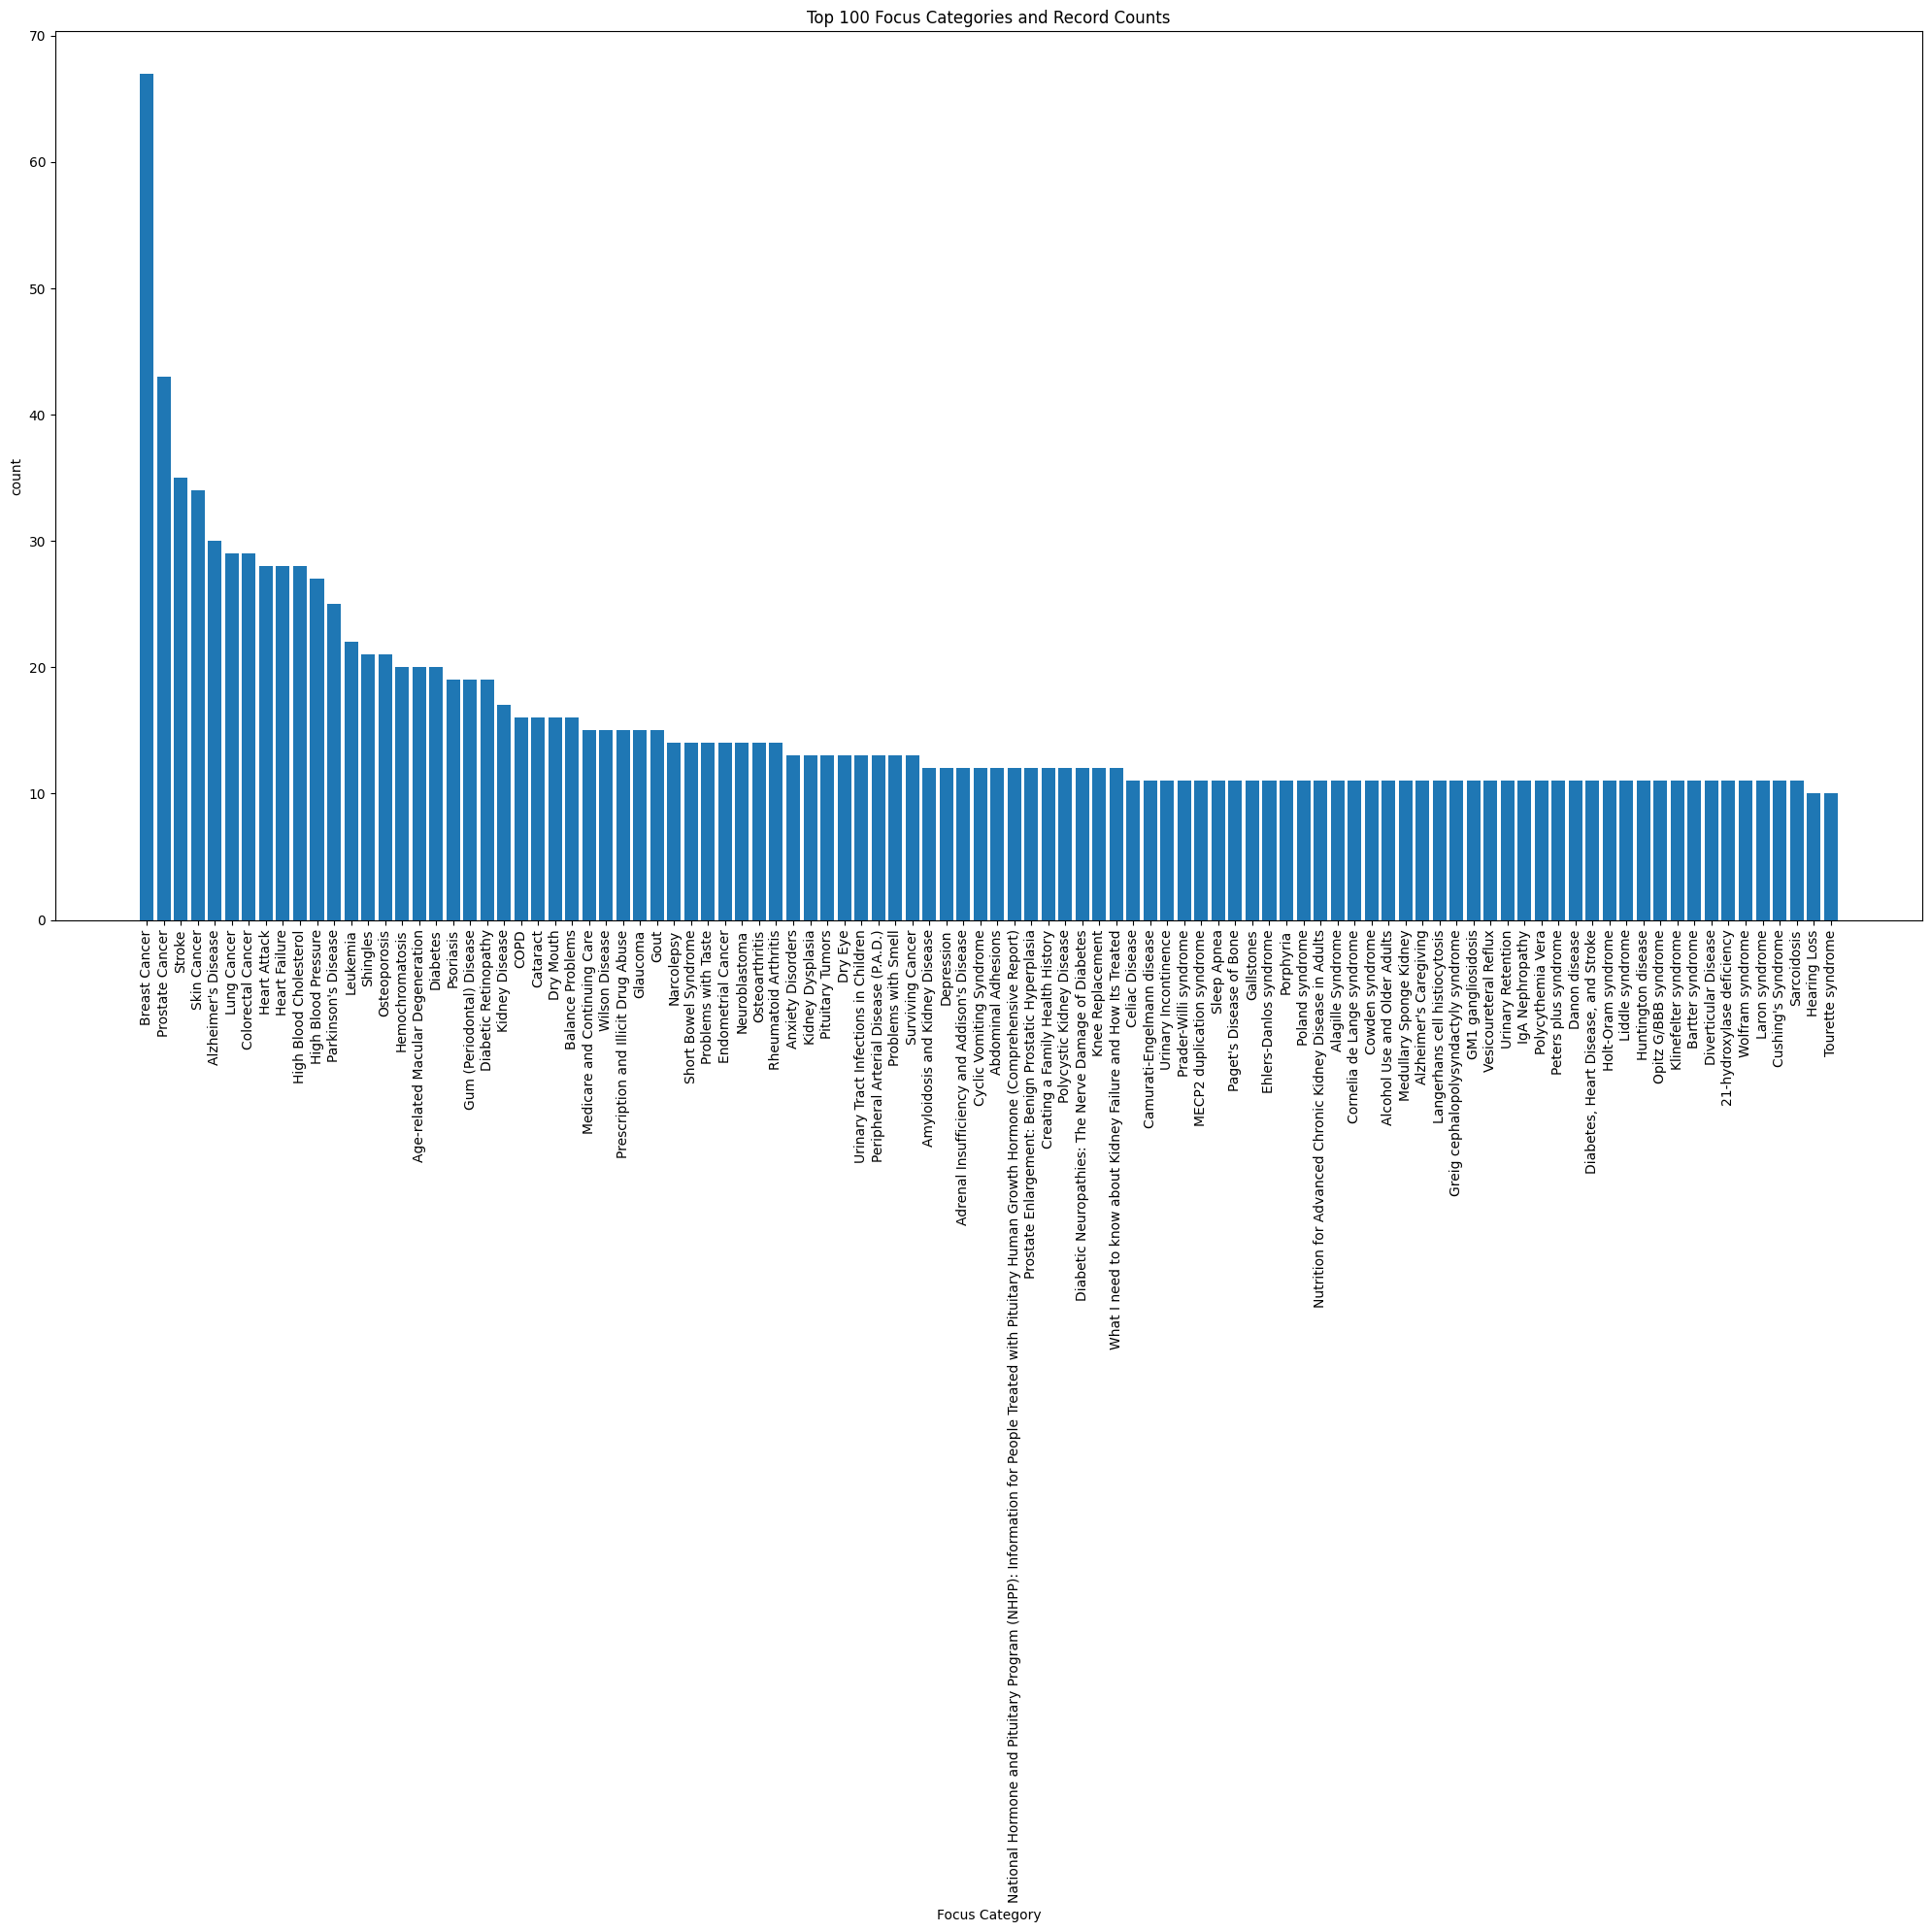

In [ ]:
dff = data["Focus"].value_counts().reset_index()
dff.columns = ["Focus", "Count"]

plt.figure(figsize=(20,20))
plt.bar(dff[0:100].Focus, dff[0:100].Count)
plt.xlabel('Focus Category')
plt.ylabel('count')
plt.title('Top 100 Focus Categories and Record Counts')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
Focus_categories = data["Focus"].value_counts()[:100]
Focus_categories = Focus_categories.index.tolist()
Focus_categories

['Breast Cancer',
 'Prostate Cancer',
 'Stroke',
 'Skin Cancer',
 "Alzheimer's Disease",
 'Lung Cancer',
 'Colorectal Cancer',
 'Heart Attack',
 'Heart Failure',
 'High Blood Cholesterol',
 'High Blood Pressure',
 "Parkinson's Disease",
 'Leukemia',
 'Shingles',
 'Osteoporosis',
 'Hemochromatosis',
 'Age-related Macular Degeneration',
 'Diabetes',
 'Psoriasis',
 'Gum (Periodontal) Disease',
 'Diabetic Retinopathy',
 'Kidney Disease',
 'COPD',
 'Cataract',
 'Dry Mouth',
 'Balance Problems',
 'Medicare and Continuing Care',
 'Wilson Disease',
 'Prescription and Illicit Drug Abuse',
 'Glaucoma',
 'Gout',
 'Narcolepsy',
 'Short Bowel Syndrome',
 'Problems with Taste',
 'Endometrial Cancer',
 'Neuroblastoma',
 'Osteoarthritis',
 'Rheumatoid Arthritis',
 'Anxiety Disorders',
 'Kidney Dysplasia',
 'Pituitary Tumors',
 'Dry Eye',
 'Urinary Tract Infections in Children',
 'Peripheral Arterial Disease (P.A.D.)',
 'Problems with Smell',
 'Surviving Cancer',
 'Amyloidosis and Kidney Disease',
 'De

### Create Training and Validation set

**Exercise 4: Create training and validation set [1 Mark]**

- Consider 4 samples per `Focus` category, for each top 100 categories, from the dataset (It will give 400 samples for training)

- Consider 1 sample per `Focus` category (different from training set), for each top 100 categories, from the dataset (It will give 100 samples for validation)

In [ ]:
train_data = pd.DataFrame()
val_data = pd.DataFrame()

for category in Focus_categories:
  tr_df = data[data["Focus"] == category].sample(n=4)
  train_data = pd.concat([train_data, tr_df], axis=0)
  val_df = data[data["Focus"] == category].sample(n=1)
  val_data = pd.concat([val_data, val_df], axis=0)

train_data.head(20)

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
11680,Breast Cancer,C0006142,T191,Disorders,What is (are) Breast Cancer ?,Breast cancer affects one in eight women durin...
567,Breast Cancer,C0006142,T191,Disorders,How to prevent Breast Cancer ?,Key Points - Avoiding risk factors and increas...
14909,Breast Cancer,C0006142,T191,Disorders,What is (are) Breast Cancer ?,How Tumors Form The body is made up of many ty...
14911,Breast Cancer,C0006142,T191,Disorders,Who is at risk for Breast Cancer? ?,What Is Cancer Prevention? Cancer prevention i...
15455,Prostate Cancer,C0376358,T191,Disorders,Who is at risk for Prostate Cancer? ?,Researchers are studying changes in genes that...
670,Prostate Cancer,C0376358,T191,Disorders,what research (or clinical trials) is being do...,New types of treatment are being tested in cli...
15438,Prostate Cancer,C0376358,T191,Disorders,What is (are) Prostate Cancer ?,"Sometimes, cancer cells break away from the ma..."
665,Prostate Cancer,C0376358,T191,Disorders,What are the symptoms of Prostate Cancer ?,Signs of prostate cancer include a weak flow o...
15532,Stroke,C0038454,T047,Disorders,what research (or clinical trials) is being do...,The National Institute of Neurological Disorde...
15545,Stroke,C0038454,T047,Disorders,What are the treatments for Stroke ?,"With stroke, treatment depends on the stage of..."


In [ ]:
train_data.shape, val_data.shape

((400, 6), (100, 6))

### Pre-process `Question` and `Answer` text

**Exercise 5: Perform below tasks:  [1 Mark]**

- Combine `Question` and `Answer` for train and validation data as shown below:
    - sequence = *'\<question\>' + question-text + '\<answer\>' + answer-text + '\<end\>'*

- Join the combined text using '\n' into a single string for training and validation separately

- Save the training and validation strings as separate text files

In [ ]:
train_data.head()

,Focus,CUI,SemanticType,SemanticGroup,Question,Answer
11680,Breast Cancer,C0006142,T191,Disorders,What is (are) Breast Cancer ?,Breast cancer affects one in eight women durin...
567,Breast Cancer,C0006142,T191,Disorders,How to prevent Breast Cancer ?,Key Points - Avoiding risk factors and increas...
14909,Breast Cancer,C0006142,T191,Disorders,What is (are) Breast Cancer ?,How Tumors Form The body is made up of many ty...
14911,Breast Cancer,C0006142,T191,Disorders,Who is at risk for Breast Cancer? ?,What Is Cancer Prevention? Cancer prevention i...
15455,Prostate Cancer,C0376358,T191,Disorders,Who is at risk for Prostate Cancer? ?,Researchers are studying changes in genes that...


- **Combine Question and Answer for train and val data**

In [ ]:
train_sequences = []
for index, row in train_data.iterrows():
  sequence = '<question>' + row['Question'] + '<answer>' + row['Answer'] + '<end>'
  train_sequences.append(sequence)

val_sequences = []
for index, row in val_data.iterrows():
  sequence = '<question>' + row['Question'] + '<answer>' + row['Answer'] + '<end>'
  val_sequences.append(sequence)

- **Join the combined text using '\n' into a single string for training and validation separately**

In [ ]:
# Train and Validation text for all Q&As
# - **Join the combined text using '\n' into a single string**
train_text = '\n'.join(train_sequences)
val_text = '\n'.join(val_sequences)


train_text

'<question>What is (are) Breast Cancer ?<answer>Breast cancer affects one in eight women during their lives. Breast cancer kills more women in the United States than any cancer except lung cancer. No one knows why some women get breast cancer, but there are a number of risk factors. Risks that you cannot change include - Age - the chance of getting breast cancer rises as a woman gets older - Genes - there are two genes, BRCA1 and BRCA2, that greatly increase the risk. Women who have family members with breast or ovarian cancer may wish to be tested. - Personal factors - beginning periods before age 12 or going through menopause after age 55 Other risks include being overweight, using hormone replacement therapy (also called menopausal hormone therapy), taking birth control pills, drinking alcohol, not having children or having your first child after age 35 or having dense breasts. Symptoms of breast cancer may include a lump in the breast, a change in size or shape of the breast or dis

- **Save the training and validation strings as text files**

In [ ]:
# Save the training and validation data as text files
# - **Save the training and validation strings as separate text files**
with open('train_data.txt', 'w') as f:
  f.write(train_text)

with open('val_data.txt', 'w') as f:
  f.write(val_text)

In [ ]:
with open('val_data.txt', 'r') as f:
  val_data_contents = f.read()

print(val_data_contents[0:1000])

<question>What are the treatments for Breast Cancer ?<answer>Certain drugs that have been used successfully in other cancers are now being used to treat some breast cancers. A mix of drugs may increase the length of time you will live, or the length of time you will live without cancer. In addition, certain drugs like Herceptin and Tykerb taken in combination with chemotherapy, can help women with specific genetic breast cancer mutations better than chemotherapy alone.<end>
<question>What are the treatments for Prostate Cancer ?<answer>There are a number of ways to treat prostate cancer, and the doctor will develop a treatment to fit each man's needs. The choice of treatment mostly depends on the stage of the disease and the grade of the tumor. But doctors also consider a man's age, general health, and his feelings about the treatments and their possible side effects. Treatment for prostate cancer may involve watchful waiting, surgery, radiation therapy, or hormonal therapy. Some men r

**Load pre-trained GPT2Tokenizer**


In [ ]:
# Set up the tokenizer
model = 'gpt2'

gpt_tokenizer = GPT2Tokenizer.from_pretrained(model, padding_side='left', model_max_length=512)
gpt_tokenizer.add_special_tokens({'pad_token': '[PAD]', 'bos_token': '<|startoftext|>', 'eos_token': '<|endoftext|>'})

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

2

**Tokenize train and validation data **

- Use the loaded pre-trained tokenizer
- Use training and validation data saved in text files


In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("text", data_files={'train_data.txt'})
val_dataset = load_dataset("text", data_files={'val_data.txt'})
val_dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 100
    })
})

**Create a DataCollator object**

Data collators are objects that:

- will form a batch by using a list of dataset elements as input
- may apply some processing (like padding)

One of the data collators, `DataCollatorForLanguageModeling`, can also apply some random data augmentation (like random masking) on the formed batch.

<br>

`DataCollatorForLanguageModeling` is a data collator used for language modeling. Inputs are dynamically padded to the maximum length of a batch if they are not all of the same length.

Parameters:

- ***tokenizer:*** The tokenizer used for encoding the data.
- ***mlm*** (bool, optional, default=True): Whether or not to use masked language modeling.
    - If set to False, the labels are the same as the inputs with the padding tokens ignored (by setting them to -100).
    - Otherwise, the labels are -100 for non-masked tokens and the value to predict for the masked token.
- ***return_tensors*** (str): The type of Tensor to return. Allowable values are “np”, “pt” and “tf” for numpy array, pytorch tensor, and tensorflow tensor respectively.

To know more about `DataCollatorForLanguageModeling` parameters, refer [here](https://huggingface.co/docs/transformers/v4.32.0/en/main_classes/data_collator#transformers.DataCollatorForLanguageModeling).

In [ ]:

# GPT-2 is a causal language model which is not compatible with MLM, hence mlm = True wont be accepted
# Using DataCollator plus GptTokenizer for preprocessing
data_collator = DataCollatorForLanguageModeling(tokenizer= gpt_tokenizer, mlm = False, return_tensors='pt')

processed_train_data = data_collator([gpt_tokenizer(text, padding=True, truncation=True) for text in train_dataset['train']['text']])
processed_val_data = data_collator([gpt_tokenizer(text, padding=True, truncation=True) for text in val_dataset['train']['text']])
processed_train_data

{'input_ids': tensor([[50257, 50257, 50257,  ...,    27,   437,    29],
        [   27, 25652,    29,  ...,  4890,  6926,   351],
        [   27, 25652,    29,  ...,  2842,   284,  4886],
        ...,
        [50257, 50257, 50257,  ..., 29847,   437,    29],
        [50257, 50257, 50257,  ..., 29847,   437,    29],
        [50257, 50257, 50257,  ...,    27,   437,    29]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'labels': tensor([[ -100,  -100,  -100,  ...,    27,   437,    29],
        [   27, 25652,    29,  ...,  4890,  6926,   351],
        [   27, 25652,    29,  ...,  2842,   284,  4886],
        ...,
        [ -100,  -100,  -100,  ..., 29847,   437,    29],
        [ -100,  -100,  -100,  ..., 29847,   437,    29],
        [ -100,  -100,  -100,  ...,    27,   437,    29]])}

**Load pre-trained GPT2LMHeadModel**


In [ ]:
# Set up the model

gptHeadModel = GPT2LMHeadModel.from_pretrained(model)
gptHeadModel.resize_token_embeddings(len(gpt_tokenizer))

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(50259, 768)

** Fine-tune GPT2 Model *

- Specify training arguments and create a TrainingArguments object (Use 30 epochs)

- Train a GPT-2 model using the provided training arguments

- Save the resulting trained model and tokenizer to a specified output directory

In [ ]:
# Set up the training arguments



# training_args = TrainingArguments(
#     output_dir=model_output_path,
#     overwrite_output_dir=True,
#     num_train_epochs= 2,
#     per_device_train_batch_size= 64,
#     per_device_eval_batch_size= 16,
#     eval_strategy='epoch', metric_for_best_model='accuracy')

model_output_path = "/content/saved_gpt_model"
train_dataset= processed_train_data['input_ids']
eval_dataset= processed_val_data['input_ids']
model = gptHeadModel

from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

model.gradient_checkpointing_enable()

args = TrainingArguments(
    output_dir= model_output_path,
    overwrite_output_dir=True,
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs= 100,
    seed=0,
    fp16=True,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    optimizers=(optimizer, None),
    train_dataset= train_dataset,
    eval_dataset= eval_dataset,
    data_collator=data_collator
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [ ]:
# Train the model
trainer.train()

trainer.save_model(model_output_path)
gpt_tokenizer.save_pretrained(model_output_path)

!zip -r /content/fineTuned_Medi_gpt_model.zip "/content/saved_gpt_model"
from google.colab import files
files.download("/content/fineTuned_Medi_gpt_model.zip") #download for future purpose

Step,Training Loss,Validation Loss
500,1.471800,1.979160
1000,0.573000,2.136423


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


  adding: content/saved_gpt_model/ (stored 0%)
  adding: content/saved_gpt_model/checkpoint-52/ (stored 0%)
  adding: content/saved_gpt_model/checkpoint-52/trainer_state.json (deflated 55%)
  adding: content/saved_gpt_model/checkpoint-52/scheduler.pt (deflated 54%)
  adding: content/saved_gpt_model/checkpoint-52/model.safetensors (deflated 7%)
  adding: content/saved_gpt_model/checkpoint-52/rng_state.pth (deflated 25%)
  adding: content/saved_gpt_model/checkpoint-52/optimizer.pt (deflated 8%)
  adding: content/saved_gpt_model/checkpoint-52/generation_config.json (deflated 24%)
  adding: content/saved_gpt_model/checkpoint-52/config.json (deflated 51%)
  adding: content/saved_gpt_model/checkpoint-52/training_args.bin (deflated 52%)
  adding: content/saved_gpt_model/vocab.json (deflated 68%)
  adding: content/saved_gpt_model/checkpoint-500/ (stored 0%)
  adding: content/saved_gpt_model/checkpoint-500/trainer_state.json (deflated 58%)
  adding: content/saved_gpt_model/checkpoint-500/schedu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def generate_response_finetuned_gpt2(model, tokenizer, prompt, max_length=200):
  if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
  input_ids = tokenizer.encode(prompt, return_tensors='pt')
  print("Input_encoding: ")
  print(input_ids)
  output = model.generate(input_ids, pad_token_id=tokenizer.pad_token_id, max_length=max_length)
  print("output_encoding: ")
  print(output[0])
  generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
  return generated_text

In [ ]:
model_saved_path = '/content/saved_gpt_model/checkpoint-1300'
saved_model = GPT2LMHeadModel.from_pretrained(model_saved_path)
saved_tokenizer = GPT2Tokenizer.from_pretrained(model_output_path)
prompt = "symptoms of Adult Acute Lymphoblastic Leukemia"
# prompt = "ymptoms of breast cancer "
response_model1300 = generate_response_finetuned_gpt2(saved_model, saved_tokenizer, prompt)
response_model1300

Input_encoding: 
tensor([[37047, 35533,   286, 21171,  4013,  1133,   406, 20896, 45292,  3477,
          1004, 43505]])
output_encoding: 
tensor([37047, 35533,   286, 21171,  4013,  1133,   406, 20896, 45292,  3477,
         1004, 43505,   357,  2390,    43,     8, 19148,   398,   274,   290,
         5334, 21415, 18634, 12168,  5087,  4588,   262,  1781,   286, 14352,
          616,   417,  1868, 49030,   357,  2390,    43,   828,   543, 17806,
          422,  5827,   284,  5827,    13,  2773,  3871,  1205,   616,   417,
         1868, 49030,   379,   281,  2961,  3800,   286,   262,  4369,   621,
         1854,    11,  7186,   287, 10726,  2356,   290,   584,  7460,    13,
          770,  6843, 13692,   319,   262,  2176,  7612,   286, 14352,   616,
          417,  1868, 49030,   357,  2390,    43,   828, 10759,   319,   262,
         7460,   290,  4542,  3689,   326,   743,   307,  1695,   284,  3871,
           13,  8549, 25458, 21234,  4542,   318,  1912,   319,  8668,  6373,
   

'symptoms of Adult Acute Lymphoblastic Leukemia (AML) Syndromes and Their Treatment Options Several factors influence the course of acute myeloid leukemia (AML), which varies from patient to patient. Some patients develop myeloid leukemia at an earlier stage of the disease than others, resulting in chronic pain and other symptoms. This chapter focuses on the specific aspects of acute myeloid leukemia (AML), focusing on the symptoms and management options that may be available to patients. Management Methods Clinical management is based on clinical findings and patient experiences, and results may vary. Although myeloid leukemia treatment is well tolerated in most parts of the country, results may not be equally so in other parts of the country. Management Methods Clinical management is based on clinical findings and patient experiences, and results may vary. Although myeloid leukemia treatment is well tolerated in most parts of the country, results may not be equally so in other parts 

In [ ]:
model_saved_path = '/content/saved_gpt_model/checkpoint-1000'
saved_model = GPT2LMHeadModel.from_pretrained(model_saved_path)
saved_tokenizer = GPT2Tokenizer.from_pretrained(model_output_path)

prompt = "symptoms of Adult Acute Lymphoblastic Leukemia" #"symptoms of breast cancer "
response_model1000 = generate_response_finetuned_gpt2(saved_model, saved_tokenizer, prompt)
response_model1000

Input_encoding: 
tensor([[37047, 35533,   286, 21171,  4013,  1133,   406, 20896, 45292,  3477,
          1004, 43505]])
output_encoding: 
tensor([37047, 35533,   286, 21171,  4013,  1133,   406, 20896, 45292,  3477,
         1004, 43505,   357,  2390,    43,     8, 19148,   398,   274,   290,
         5334, 21415, 18634, 12168,  5087,  4588,   262,  1781,   286, 14352,
          616,   417,  1868, 49030,   357,  2390,    43,   828,  1390,  8513,
           11,  6142,    11,   290,  1641,  2106,    13,  4900,   616,   417,
         1868, 49030,   318,   262,   749,  2219,  2099,   286, 49030,   287,
          262,  1578,  1829,    11,   340,  5504,   329,   517,   621,   257,
         2368,   286,   477,   649,  2663,  2098,   287,   262,  1578,  1829,
         1022,  3050,   290,  1946,    13, 31572,   278, 29521,  2011,   417,
         1868,  1004, 43505,   554,  1946,    11,  3162, 17814,   262,  2351,
         3893,   290, 23285, 50105, 13084,   357, 33863,  1565,  1546,     8,
   

'symptoms of Adult Acute Lymphoblastic Leukemia (AML) Syndromes and Their Treatment Options Several factors influence the course of acute myeloid leukemia (AML), including genetic, environmental, and family history. Although myeloid leukemia is the most common type of leukemia in the United States, it accounts for more than a third of all new cases reported in the United States between 2010 and 2014. Preventing Secondary Myeloid Leukemia In 2014, Congress enacted the National Health and Nutrition Examination Survey (NHANES) to collect information on childhood leukemia incidence, prevalence, and complications. The NHANES collects information on childhood leukemia incidence, prevalence, and complications in the U.S. Between 1999 and 2014, the number of new cases of acute myeloid leukemia (AML) developed in the U.S. averaged 1.3 cases per 100,000 live births. Preventing Secondary Myeloid Leukemia Prevention is important because it means preventing secondary my'

In [ ]:
# Testing with a sample prompt 1
model_saved_path = '/content/saved_gpt_model'
saved_model = GPT2LMHeadModel.from_pretrained(model_saved_path)
saved_tokenizer = GPT2Tokenizer.from_pretrained(model_output_path)

response_model = generate_response_finetuned_gpt2(saved_model, saved_tokenizer, prompt)
response_model

Input_encoding: 
tensor([[37047, 35533,   286, 21171,  4013,  1133,   406, 20896, 45292,  3477,
          1004, 43505]])
output_encoding: 
tensor([37047, 35533,   286, 21171,  4013,  1133,   406, 20896, 45292,  3477,
         1004, 43505,   357,  2390,    43,     8, 38103,  1773, 10036, 38103,
         1773, 10036,   318,   257,  2219,  4168,  4006,   326, 10975,   546,
         1542,  1411,   286,   661,   287,   262,  1578,  1829,    13,   383,
         4006,   318, 16264,   416,   257,  4168, 28509,   326, 26779,   422,
          262,  4168,   284,   262, 28837, 13760,    11,   290,   340,   460,
          938,   422,   257,  1178,  1528,   284,   812,    13,  4380,   351,
          428,  4168,  4006,  1690,   423,   645,  7460,    13,  2102,    11,
          340,   460,  2728,  4168,  2761,    11,   884,   355,  2356,    11,
        29844,    11,   290,  2266,  1108,    13,  4380,   351,   428,  4168,
         4006,  1690,   423,   645,  5895,   393,  7460,    13,  2102,    11,
   

'symptoms of Adult Acute Lymphoblastic Leukemia (AML) Nephropathy Nephropathy is a common skin condition that affects about 30 percent of people in the United States. The condition is characterized by a skin rash that spreads from the skin to the lymph nodes, and it can last from a few days to years. People with this skin condition often have no symptoms. However, it can cause skin problems, such as pain, swelling, and redness. People with this skin condition often have no signs or symptoms. However, it can cause skin problems, such as pain, swelling, and redness. (Photo by Dan Kitwood/Getty Images) Nephropathy Nephropathy is a common skin condition that affects about 30 percent of people in the United States. The condition is characterized by a skin rash that spreads from the skin to the lymph nodes, and it can last from a few days to years. People with this skin condition often have no signs or symptoms.'

** Compare the performance of a *GPT2 model* with the *GPT2 model fine-tuned* on MedQuAD data **

- Load another pre-trained GPT2LMHeadModel and do not fine-tune it

- To generate response using the untuned model, pass it as a parameter to `generate_response()` function

- Test both models (fine-tuned and untuned) using few user input prompts:


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Loading pre-trained GPT-2 model and tokenizer
model_name = "gpt2" # Model size can be switched accordingly (e.g., "gpt2-medium")
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Set the model to evaluation mode
model.eval()


def generate_text(prompt, max_length=100, temperature=0.8, top_k=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(
        input_ids,
        max_length=max_length,
        temperature=temperature,
        top_k=top_k,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True
    )
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

answer_text_gpt_untuned = generate_text(prompt)
answer_text_gpt_untuned

'symptoms of Adult Acute Lymphoblastic Leukemia (ALS)\n\nThe symptoms of Lymphophilia can be seen in a number of different places in the body. Here are some examples of signs:\n\nFrequent breathing with very frequent breathing problems\n\nFrequent breathing problems often with coughing and/or sneezing.\n\nTrouble swallowing (usually with difficulty)\n\nUnusual vomiting.\n\nFrequent crying.\n\nDifficulty walking.\n'

In [ ]:
print("Untuned GPT2 response:" +  answer_text_gpt_untuned)
print("FineTuned GPT2 checkpoint 1000steps:" +  response_model1000)
print("FineTuned GPT2 checkpoint 1300steps:" +  response_model1300)
print("FineTuned GPT2 checkpoint final:" +  response_model)

Untuned GPT2 response:symptoms of Adult Acute Lymphoblastic Leukemia (ALS)

The symptoms of Lymphophilia can be seen in a number of different places in the body. Here are some examples of signs:

Frequent breathing with very frequent breathing problems

Frequent breathing problems often with coughing and/or sneezing.

Trouble swallowing (usually with difficulty)

Unusual vomiting.

Frequent crying.

Difficulty walking.

FineTuned GPT2 checkpoint 1000steps:symptoms of Adult Acute Lymphoblastic Leukemia (AML) Syndromes and Their Treatment Options Several factors influence the course of acute myeloid leukemia (AML), including genetic, environmental, and family history. Although myeloid leukemia is the most common type of leukemia in the United States, it accounts for more than a third of all new cases reported in the United States between 2010 and 2014. Preventing Secondary Myeloid Leukemia In 2014, Congress enacted the National Health and Nutrition Examination Survey (NHANES) to collect 

In [ ]:
# prompt: can you change above code with LoRA fine tuning method?

import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments, BitsAndBytesConfig
from google.colab import drive
import warnings
from transformers import AdamW
from google.colab import files

# ... (rest of your existing code)

# LoRA Configuration
lora_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load pre-trained GPT2LMHeadModel with LoRA
gptHeadModel = GPT2LMHeadModel.from_pretrained(model, quantization_config=lora_config, device_map={"":0})
gptHeadModel.resize_token_embeddings(len(gpt_tokenizer))

# ... (rest of your existing code, including training loop)

# Modify the Trainer initialization to include LoRA parameters
trainer = Trainer(
    model=model,
    args=args,
    optimizers=(optimizer, None),
    train_dataset= train_dataset,
    eval_dataset= eval_dataset,
    data_collator=data_collator
)

# ... (rest of your code)


In [ ]:
# prompt: what are the difference of LoRA tuning and full tuning?

LoRA (Low-Rank Adaptation) and full fine-tuning are both methods for adapting a pre-trained language model to a specific downstream task, but they differ in how they modify the model's weights:

**Full Fine-Tuning:**

* **Method:**  All the weights of the pre-trained model are updated during training.
* **Resource Intensity:**  Requires significantly more computational resources (GPU memory and processing power) and training time, especially for large models.
* **Performance:**  Generally achieves higher performance as it can make more substantial adjustments to the model.
* **Catastrophic Forgetting:**  More prone to catastrophic forgetting, where the model forgets previously learned knowledge while adapting to the new task.  Careful tuning and regularization are essential.


**LoRA (Low-Rank Adaptation):**

* **Method:** Instead of updating all weights, LoRA introduces small, trainable matrices (rank decomposition matrices) to each weight matrix of selected layers.  Only these small matrices are updated during training, while the original pre-trained weights remain frozen.
* **Resource Intensity:**  Significantly less resource-intensive than full fine-tuning.  Requires much less GPU memory and trains faster.  This allows for fine-tuning of very large models that might not fit into memory otherwise.
* **Performance:**  Often achieves performance comparable to or even close to full fine-tuning, especially when the downstream dataset is not too different from the pre-training data.
* **Catastrophic Forgetting:**  Less susceptible to catastrophic forgetting since the original pre-trained weights are preserved.


**In summary:**

| Feature          | Full Fine-Tuning | LoRA                       |
|------------------|-------------------|----------------------------|
| Weights Updated   | All               | Small rank decomposition matrices |
| Resource Usage    | High              | Low                        |
| Training Time     | Long              | Short                      |
| Performance       | Potentially Higher | Often comparable or close  |
| Catastrophic Forgetting | Higher            | Lower                      |


**When to Use Which:**

* **LoRA:** Ideal for situations where you have limited computational resources, want to fine-tune large models, or prioritize faster training times.  It's a good starting point.
* **Full Fine-Tuning:** Preferred when you need the absolute best performance possible and have ample resources available.  Also consider if your downstream task is very different from the pre-training data.


In [ ]:
# prompt: how to print weights and compare both LORA vs Full fine tuned GPT?

import torch

def compare_weights(full_finetuned_model_path, lora_model_path):
  """
  Compares the weights of a full fine-tuned GPT-2 model and a LoRA-adapted GPT-2 model.

  Args:
    full_finetuned_model_path: Path to the full fine-tuned model.
    lora_model_path: Path to the LoRA-adapted model.
  """

  try:
    # Load full fine-tuned model
    full_model = GPT2LMHeadModel.from_pretrained(full_finetuned_model_path)

    # Load LoRA model
    lora_model = GPT2LMHeadModel.from_pretrained(lora_model_path)

    # Compare weights (example: comparing the first layer's weight)
    for name, param in full_model.named_parameters():
      if name in lora_model.named_parameters():
        lora_param = lora_model.get_parameter(name)
        if param.shape == lora_param.shape:
            diff = torch.norm(param - lora_param)
            print(f"Weight difference for {name}: {diff}")
        else:
            print(f"Weight shapes do not match for {name}")
      else:
        print(f"Parameter {name} not found in LoRA model.")
  except Exception as e:
    print(f"An error occurred: {e}")


# Example usage (replace with your actual model paths):
full_finetuned_model_path = '/content/saved_gpt_model'
lora_model_path = '/content/lora_model'  # Replace with the path to your LoRA model

compare_weights(full_finetuned_model_path, lora_model_path)
